In [7]:
from osgeo import gdal
import os, shutil
import numpy as np
gdal.UseExceptions()
import rasterio as rio

def array_to_raster(tpl_file,dst_file,array,nodata):
    # reference: https://gis.stackexchange.com/questions/164853/reading-modifying-and-writing-a-geotiff-with-gdal-in-python
    ds = gdal.Open(tpl_file)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    [cols, rows] = arr.shape

    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(dst_file, rows, cols, 1, gdal.GDT_Float32) #gdal.GDT_UInt16
    outdata.SetGeoTransform(ds.GetGeoTransform()) #set same geotransform as input
    outdata.SetProjection(ds.GetProjection()) #set the same projection as input
    outdata.GetRasterBand(1).WriteArray(array)
    outdata.GetRasterBand(1).SetNoDataValue(nodata) #if you want these values transparent
    outdata.FlushCache() #saves to disk
    return outdata.GetRasterBand(1) 

# This script is to merge mulctiple Sx calculation results and generate raster
case = 'yampa'
root_dir = '/glade/u/home/hongli/scratch/2020_11_29discretization_error/discretize'
case_dir = os.path.join(root_dir, case)
refraster = os.path.join(case_dir, 'dem_crop.tif')

row_interval=70 
col_interval=70
dem_nodata=-9999
Sx_nodata=-9999

# =======================input and output (1) =============================
dem_raster=os.path.join(case_dir, 'dem_crop.tif')
sx_result_dir=os.path.join(case_dir, 'step5_raw_Sx')
opath=os.path.join(case_dir, 'step7_merge_raw_Sx')
if not os.path.exists(opath):
    os.makedirs(opath)
ofile = 'sx.tif'  

#====================================================
# read raw raster [ELEVATION]
print('read DEM data')
r = gdal.Open(dem_raster)
band = r.GetRasterBand(1) #bands start at one
elev = band.ReadAsArray().astype(np.float)
mask = (elev==dem_nodata)
(ny,nx)=np.shape(elev)

#====================================================
# calcualte the number of row and col jobs
if ny%row_interval==0:
    row_job_num=ny//row_interval
else:
    row_job_num=ny//row_interval+1
if nx%col_interval==0:
    col_job_num=nx//col_interval
else:
    col_job_num=nx//col_interval+1        

#=======================================================================================
# read all Sx results            
print('read Sx results')
sx_arr = np.empty_like(elev)
for i in range(row_job_num):
    for j in range(col_job_num):
        
        row_start = i*row_interval
        col_start = j*col_interval
        if (ny%row_interval!=0) and (i==row_job_num-1):
            row_end=row_start+ny%row_interval
        else:
            row_end = (i+1)*row_interval
        if (nx%col_interval!=0) and (j==col_job_num-1):
            col_end = col_start+nx%col_interval
        else:
            col_end = (j+1)*col_interval 
            
        mask_subset = mask[row_start:row_end,col_start:col_end]
        if not mask_subset.all()==True:        
            ofile='Sx_Row'+str(row_start)+'_'+str(row_end)+'_Col'+str(col_start)+'_'+str(col_end)+'.txt'
            sx_arr[row_start:row_end,col_start:col_end]=np.loadtxt(os.path.join(sx_result_dir,ofile),delimiter=',')
        else:
            sx_arr[row_start:row_end,col_start:col_end]=Sx_nodata

#====================================================
print('save Sx raster')
# # method 1: GDAL save array
# sx_arr[mask==True]=np.nan
# array_to_raster(dem_raster,os.path.join(opath,ofile_raster),sx_arr,Sx_nodata)

# method 2: rasterio save masked array
with rio.open(refraster) as ff:
    ref_mask = ff.read_masks(1)
    out_meta = ff.meta.copy()
out_meta.update(count=1, dtype='float64', compress='lzw', nodata=Sx_nodata)

# save into rasters
sx_arr[np.isnan(sx_arr)]=Sx_nodata
sx_ma = np.ma.masked_array(sx_arr,out_meta==0)
with rio.open(os.path.join(opath,ofile), 'w', **out_meta) as outf:
    outf.write(sx_ma, 1)    

print('Done')

read DEM data
read Sx results
save Sx raster
Done


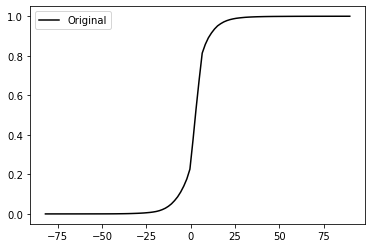

In [14]:
# Choose how many bins you want here
num_bins = 100

# raw sw and its area-based cdf
with rio.open(os.path.join(opath,ofile)) as ff:
    sx  = ff.read(1)
    sx_mask = ff.read_masks(1)
origin_counts, origin_bin_edges = np.histogram(sx[sx_mask!=0], bins=num_bins)

cum_counts = np.cumsum(origin_counts)
total_count = cum_counts[-1]
origin_cdf = cum_counts/float(total_count)

# Plot comparatives cdf
fig, ax = plt.subplots()
ax.plot(origin_bin_edges[1:], origin_cdf, '-k', label='Original')
plt.legend(loc='best')
plt.show()